In [2]:
%load_ext autoreload
%autoreload 2
import platform
import os

gdrive = False
linux = True 
# Detect if we're running on a Linux system
linux = platform.system() == "Linux"

# Detect if we're in a Google Colab environment by attempting to import google.colab
try:
    from google.colab import drive
# Mount Google Drive
    drive.mount('/content/drive')
    gdrive=True
except ImportError:
    gdrive = False

# Detect if we're in a Kaggle environment by checking for a Kaggle-specific environment variable
kaggle = "KAGGLE_URL_BASE" in os.environ
environment_flags = {'kaggle': kaggle, 'gdrive': gdrive, 'linux': linux}
print("Environment settings:", environment_flags)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Environment settings: {'kaggle': False, 'gdrive': False, 'linux': True}


In [3]:
import os
os.chdir('/home/zano/Documents/TESI/FOLDER_CINECA/')
print(os.getcwd())

/home/zano/Documents/TESI/FOLDER_CINECA


## install requirements

## IMPORTS

In [3]:
!python --version   

Python 3.12.3


In [4]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install -r requirementsaaaa.txt

  Using cached pretrained_microscopy_models-0.1.0-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [6]:
%ls

best_model_fold_0.pth                 mlruns/
best_model_fold_1.pth                 notebooks/
best_model_fold_2.pth                 pretrained_encoders/
best_model_fold_3.pth                 README.txt
best_model_fold_4.pth                 requirementsaaaa.txt
best_model_fold_5.pth                 requirements.txt
best_model_fold_6.pth                 simclr_pretraining.py
best_model_fold_7.pth                 simple_image_checker.py
byol_simsiam_pretraining.py           slurm_files/
classes/                              snelled_requirements.txt
configs/                              ssl_d121_3c-17253692.out
confusion_matrices/                   submit_all_3c.sh*
data/                                 submit_all_4c.sh*
downstream_supervised_fine_tuning.py  submit_all_pretrained.sh*
learning_curves/                      supervised_learning.py
lightning_logs/                       train_3c.py
logs/                                 train_4c.py
mlflow.log                            train_pre

In [7]:
# Activate your virtual environment
!source ~/Documents/TESI/FOLDER_CINECA/.venv/bin/activate

In [4]:
import os
import tifffile
import glob
import random
import torch
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim
import numpy as np
# from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
# from sklearn.model_selection import StratifiedKFold
from monai.data import Dataset, DataLoader
# from classes.PrintShapeTransform import PrintShapeTransform
from monai.utils.misc import set_determinism
import monai
print(monai.__version__)
import cv2
#import tifffile
#from monai.networks.nets import DenseNet121
import torch.nn.functional as F
from monai.visualize import GradCAMpp,GradCAM  
import pytorch_lightning
#kaggle = input("Are you on Kaggle? Enter 'T' for True or 'F' for False: ")
kaggle = False
if gdrive:
    import os

    # Change to the desired directory:
    os.chdir('/content/drive/MyDrive/TESI/TESI/notebooks')

    # Verify the current directory:
    print(os.getcwd())

def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
# Import the set_global_seed function or define it if not available
try:
    from utils.reproducibility_functions import set_global_seed
    set_global_seed(42)
except (ImportError, NameError) as e:
    # Define the function locally if import fails
    def set_global_seed(seed):
        """Set seed for all sources of randomness to ensure reproducibility."""
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        # Set deterministic behavior for CUDA
        if torch.cuda.is_available():
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
        # Set monai determinism
        set_determinism(seed=seed)
        
    set_global_seed(42)

2.6.0+cu124
1.4.0


## PARAMETERS THAT WILL GET LOGGED ON MLFLOW

In [5]:
import sys
# Add the parent directory to Python path to make configs package accessible
from configs.ConfigLoader import ConfigLoader
sys.path.append(os.path.dirname(os.getcwd()))

yaml_path = "/home/zano/Documents/TESI/FOLDER_CINECA/configs/4c/base.yaml"
colab_yaml_path = "/content/drive/MyDrive/TESI/FOLDER_CINECA/configs/base.yaml"
try:
    cfg = ConfigLoader(yaml_path)
except ValueError as e:
    print(f"Error loading configuration: {e}")
    print("Please ensure the YAML file contains all required sections.")
    raise

# Set a fixed random seed for reproducibility for all the soruces of randomness
# python, numpy, torch, monai
SEED = 42
# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
set_determinism(seed=SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
import torch.backends.cudnn as cudnn
cudnn.deterministic = True   # forces deterministic convolution algorithms
cudnn.benchmark     = False  # turn off data-dependent autotune
# monai.utils.set_determinism(seed=SEED)

Configuration loaded from /home/zano/Documents/TESI/FOLDER_CINECA/configs/4c/base.yaml
Configuration: {'dataset': {'class_names': ['MSA-P', 'PD']}, 'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 8}, 'data_augmentation': {'resize_spatial_size': [512, 512], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.5, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1}, 'data_loading': {'batch_size': 64, 'num_workers': 4}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 4, 'out_channels': 2, 'dropout_prob': 0.1, 'patch_size': [32, 32], 'library': 'torchvision'}, 'training': {'num_epochs': 50, 'early_stopping_patience': 17, 'mixup_alpha': 0, 'oversample': True, 'undersample': False, 'weighted_loss': False, 'fine_tuning': False, 'transfer_learning': False, 'freezed_layerIndex': None}, 'optimizer': {'learning_rate': '1e-4', 'optimizer

# UNIFIED DATA SELECTION

In [10]:
import os

# Define the path for the MLflow tracking directory and its trash folder
mlruns_path = "/home/zano/Documents/TESI/FOLDER_CINECA/mlruns"
trash_path = os.path.join(mlruns_path, ".trash")

# Create the directories if they don't exist
os.makedirs(trash_path, exist_ok=True)

os.environ["DATA_ROOT"] = "/home/zano/Documents/TESI/FOLDER_CINECA/data"
os.environ["PROJ_ROOT"] = "/home/zano/Documents/TESI/FOLDER_CINECA"
os.environ["MLFLOW_TRACKING_URI"] = f"file:{mlruns_path}"

In [62]:
from utils.directory_functions import get_data_and_base_directory
num_input_channels = int(input("Enter the number of input channels (3 or 4): "))
data_dir, base_dir = get_data_and_base_directory(num_input_channels)
print("data dir:",data_dir)
print("base_dir:",base_dir)

# start mlflow ui
from utils.mlflow_functions import *
from utils.directory_functions import *

tracking_uri = get_tracking_uri()
mlflow.set_tracking_uri(tracking_uri)
start_mlflow_ui_locally(tracking_uri) # start mlflow ui

data dir: /home/zano/Documents/TESI/FOLDER_CINECA/data/4c_MIP
base_dir: /home/zano/Documents/TESI/FOLDER_CINECA
Linux detected, setting tracking URI
Final Tracking URI: file:/home/zano/Documents/TESI/FOLDER_CINECA/mlruns
Does the directory exist? True


In [63]:
import ipywidgets as widgets
from IPython.display import display

CLASS_NAME_SETS = {
    "MSA vs Control": ["MSA", "control"],
    "MSA vs PD": ["MSA", "PD"],
    "MSA-P vs MSA-C": ["MSA-P", "MSA-C"],
    "MSA-P vs PD": ["MSA-P", "PD"],
    "PD vs MSA-P vs MSA-C": ["PD", "MSA-P", "MSA-C"]
}

dropdown = widgets.Dropdown(
    options=list(CLASS_NAME_SETS.keys()),
    value="MSA vs PD",
    description='Class Set:',
    style={'description_width': 'initial'}
)

def on_dropdown_change(change):
    """
    Update the class_names variable when the dropdown selection changes.
    """
    global class_names
    if change['type'] == 'change' and change['name'] == 'value':
        class_names = CLASS_NAME_SETS[change['new']]
        print(f"class_names set to: {class_names}")


class_names = CLASS_NAME_SETS[dropdown.value]

dropdown.observe(on_dropdown_change)

display(dropdown)

Dropdown(description='Class Set:', index=1, options=('MSA vs Control', 'MSA vs PD', 'MSA-P vs MSA-C', 'MSA-P v…

In [64]:
print(f"class_names set to: {class_names}") #chekc if the class names are set correctly

class_names set to: ['MSA', 'PD']


# DATA EXTRACTION

{'MSA': '/home/zano/Documents/TESI/FOLDER_CINECA/data/4c_MIP/MSA', 'PD': '/home/zano/Documents/TESI/FOLDER_CINECA/data/4c_MIP/PD'}
Class directories:
{'MSA': '/home/zano/Documents/TESI/FOLDER_CINECA/data/4c_MIP/MSA', 'PD': '/home/zano/Documents/TESI/FOLDER_CINECA/data/4c_MIP/PD'}
MSA images (before filtering): 'gh' count: 104, 'vaso' count: 0
After removing 'vaso', MSA images: 'gh' count: 104, 'vaso' count: 0
PD images (before filtering): 'gh' count: 60, 'vaso' count: 0
After removing 'vaso', PD images: 'gh' count: 60, 'vaso' count: 0


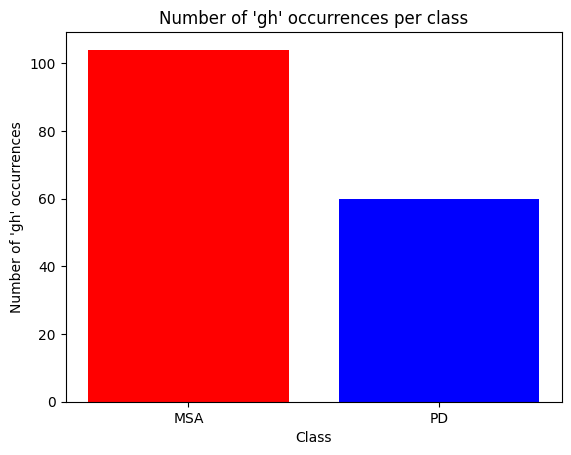


Checking image shapes:
MSA image: MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif  dtype: uint8, shape: (4, 1024, 1024)
MSA image: MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (4, 1024, 1024)
MSA image: MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif  dtype: uint8, shape: (4, 1024, 1024)
MSA image: MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (4, 1024, 1024)
MSA image: MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (4, 1024, 1024)
MSA image: MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh2.tif  dtype: uint8, shape: (4, 1024, 1024)
MSA image: MAX_5435 gh.tif  dtype: uint8, shape: (4, 1024, 1024)
MSA image: MAX_5435 gh2.tif  dtype: uint8, shape: (4, 1024, 1024)
MSA image: MAX_5463 gh.tif  dtype: uint8, 

In [65]:
# Create a dictionary mapping each class to its directory
class_dirs = {}
three_classes = (len(class_names) == 3)

for class_name in class_names:
    class_dirs[class_name] = os.path.join(data_dir, class_name)
    
print(class_dirs)
if three_classes:
    class2_name, class1_name, class0_name = class_names
    class2_dir, class1_dir, class0_dir = class_dirs.values()
else:
    class1_name, class0_name = class_names
    class1_dir, class0_dir = class_dirs.values()

print("Class directories:")
print(class_dirs)

# Dictionaries to store image paths and counts for each class
images_paths_dict = {}
counts_dict = {}

# Loop over classes to process each folder
for class_name in class_names:
    class_dir = class_dirs[class_name]
    image_paths = sorted(glob.glob(os.path.join(class_dir, "*.tif")))
    
    # Check if images were found; otherwise raise an error
    if not image_paths:
        raise FileNotFoundError(f"No TIFF image file found in {class_dir}")
    
    # Count occurrences of 'gh' and 'vaso' in the filenames (using .lower() for case insensitivity)
    gh_count = sum('gh' in os.path.basename(path).lower() for path in image_paths)
    vaso_count = sum('vaso' in os.path.basename(path).lower() for path in image_paths)
    print(f"{class_name} images (before filtering): 'gh' count: {gh_count}, 'vaso' count: {vaso_count}")
    
    # Filter out images that contain 'vaso' (if needed)
    image_paths = [path for path in image_paths if 'vaso' not in os.path.basename(path).lower()]
    gh_count_after = sum('gh' in os.path.basename(path).lower() for path in image_paths)
    vaso_count_after = sum('vaso' in os.path.basename(path).lower() for path in image_paths)
    print(f"After removing 'vaso', {class_name} images: 'gh' count: {gh_count_after}, 'vaso' count: {vaso_count_after}")
    
    # Store the filtered image paths and counts for later use
    images_paths_dict[class_name] = image_paths
    counts_dict[class_name] = {"gh_count": gh_count_after, "vaso_count": vaso_count_after}

# Visualize the number of 'gh' counts per class in a bar chart
plt.figure()
plt.xlabel("Class")
plt.ylabel("Number of 'gh' occurrences")
plt.title("Number of 'gh' occurrences per class")
bar_heights = [counts_dict[cn]["gh_count"] for cn in class_names]
bar_colors = ['red', 'blue', 'lightblue']
plt.bar(class_names, bar_heights, color=bar_colors)
plt.show()

# --- Debug: Check image shapes after initial loading ---
print("\nChecking image shapes:")
for class_name, image_paths in images_paths_dict.items():
    for path in image_paths:
        img = tifffile.imread(path)  # Read image as a numpy array
        print(f"{class_name} image: {os.path.basename(path)}  dtype: {img.dtype}, shape: {img.shape}")

# Combine image paths and labels for the three classes; 
# the label here is simply the index of the class in class_names (0, 1, 2)
combined = [] # List to store tuples of (image_path, label)
for label, class_name in enumerate(class_names):
    for path in images_paths_dict[class_name]:
        combined.append((path, label))
# print("\nSample of combined image paths and labels:", combined[:5])
random.shuffle(combined)  # Shuffle the combined list to mix classes

# Optionally, determine the minority label for resampling purposes
counts = {label: len(images_paths_dict[class_name]) for label, class_name in enumerate(class_names)}
minority_label = min(counts, key=lambda k: counts[k])
print(f"\nMinority label for resampling purposes: {minority_label}")

# Unzip the combined list back into separate tuples (if needed)
images_paths, labels = zip(*combined)
print("\nSample of image paths:", images_paths[:5])
print("Total images found:", len(combined))

# Optionally, convert to NumPy arrays (helpful for further processing or k-fold splitting)
images_paths_np = np.array(images_paths)
labels_np = np.array(labels)
print("\nSample of image paths (NumPy):", images_paths_np[:5])
print((labels_np))
#print(X)

## TEST SET SPLIT

In [68]:
# NB the test set must be splitted BEFORE oversampling to avoid data leakage!
# -------------------------------------------------------------------------
#from sklearn.model_selection import train_test_split
#returns numpy arrays containing the paths to images and the labels
# print(cfg.data_splitting["random_seed"])
train_images_paths, test_images_paths, train_true_labels, test_true_labels = train_test_split(
    images_paths_np,
    labels_np,
    test_size = cfg.data_splitting["test_set_size"],
    stratify=labels,
    random_state=42
)

test_images_paths_np = np.array(test_images_paths)
test_true_labels_np = np.array(test_true_labels)
print("train images paths:", train_images_paths)
print("true test labels:", test_true_labels)
# # For the cross-validation, we'll use train_images_paths and labels_temp
train_images_paths_np = np.array(train_images_paths) #contains the images paths
train_labels_np = np.array(train_true_labels) #contains the labels
print(f"{train_images_paths_np.shape[0]} training images")
print(f"{len(test_images_paths)} test images")
#test_images_paths = [os.path.basename(path) for path in test_images_paths]
print(test_images_paths)
print(type(train_images_paths))

train images paths: ['/home/zano/Documents/TESI/FOLDER_CINECA/data/4c_MIP/MSA/MAX_6485.lif - 6485 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif'
 '/home/zano/Documents/TESI/FOLDER_CINECA/data/4c_MIP/MSA/MAX_5904 gh.tif'
 '/home/zano/Documents/TESI/FOLDER_CINECA/data/4c_MIP/MSA/MAX_6485.lif - 6485 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif'
 '/home/zano/Documents/TESI/FOLDER_CINECA/data/4c_MIP/MSA/MAX_7210.lif - 7210 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif'
 '/home/zano/Documents/TESI/FOLDER_CINECA/data/4c_MIP/MSA/MAX_7037.lif - 7037 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh2.tif'
 '/home/zano/Documents/TESI/FOLDER_CINECA/data/4c_MIP/MSA/MAX_7857.lif - 7857 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif'
 '/home/zano/Documents/TESI/FOLDER_CINECA/data/4c_MIP/MSA/MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif'
 '/home/zano/Documents/TESI/FOLDER_CINECA/

# SUPERVISED LEARNING


## training augmentations

In [67]:
from configs import ConfigLoader
import utils.transformations_functions as tf
import utils.monai_transformation_functions as mtf
from configs.ConfigLoader import ConfigLoader

from classes.ModelManager import ModelManager
available_models = ["densenet121", "resnet18", "resnet18", "resnet50"]

yaml_path = f"/home/zano/Documents/TESI/TESI/configs/{num_input_channels}c/densenet121.yaml"
cfg = ConfigLoader(yaml_path) 
cfg.set_freezed_layer_index(None)
transfer_learning = cfg.get_transfer_learning()
pretrained_weights = "imagenet" if transfer_learning else None # 'microscopynet' or "imagenet" or 'imagenet-microscopynet' 
assert pretrained_weights in [None,"microscopynet", "imagenet", "imagenet-microscopynet"], "pretrained_weights must be one of [None, 'microscopynet', 'imagenet', 'imagenet-microscopynet']"
            # indicates that the encoder was first pretrained on imagenet and then finetuned on microscopynet
model_library = "monai" # or "torchvision" or "monai" pretraining dataset, either 'microscopynet' or 
assert model_library in ["torchvision", "monai"], "model_library must be one of ['torchvision', 'monai']"
color_transforms = False
train_transforms, val_transforms, test_transforms = tf.get_transforms(cfg, color_transforms=color_transforms)
# train_transforms, val_transforms, test_transforms = mtf.get_transforms(cfg, color_transforms=color_transforms)
model_manager = ModelManager(cfg, library=model_library)
# Verify the number of unique labels in the dataset
num_classes = len(np.unique(train_labels_np))
# print(f"Number of classes in the dataset: {num_classes}")
using_cosine_scheduler = False
# Ensure the model's output matches the number of classes
model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)
# model = model.to(device)  # First, move to the target device
# model = model.float() 
print(model)
# print(cfg.get_model_input_channels())

# if model.__class__.__name__ == "ViT":
#     print("Using ViT hence it requires custom training and validation functions")
#     train_epoch = train_epoch_vit
#     val_epoch = val_epoch_vit

Configuration loaded from /home/zano/Documents/TESI/TESI/configs/4c/base.yaml
Configuration: {'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 6}, 'data_augmentation': {'resize_spatial_size': [256, 256], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.5, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1}, 'data_loading': {'batch_size': 8, 'num_workers': 0}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 4, 'out_channels': 2, 'dropout_prob': 0.1, 'patch_size': [32, 32]}, 'training': {'num_epochs': 50, 'early_stopping_patience': 17, 'mixup_alpha': 0, 'oversample': True, 'undersample': False, 'weighted_loss': False, 'fine_tuning': False, 'transfer_learning': False, 'freezed_layerIndex': None}, 'optimizer': {'learning_rate': '1e-4', 'optimizer_name': 'Adam', 'weight_decay': '2e-5'}, 'scheduler': {'scheduler_name': 'ReduceL

## TRAINING

## NESTED K FOLD WITH HYP(LR) TUNING

This code trains an image classifier using nested cross-validation.
The outer loop evaluates the model's performance, while the inner loop (using Optuna) tunes the learning rate.
For each outer fold, Optuna finds the best learning rate by minimizing validation loss on inner folds.
The model is then retrained on the entire outer training set with this optimal learning rate and evaluated on the outer set. The final results are the average performance metrics across all outer folds. Techniques like oversampling, undersampling, and early stopping are used to improve the model's robustness and generalization.

NB: total number of epoch: n_outer_folds × n_trials × n_inner_folds × inner_num_epochs.

### outer test as test


In [17]:
import pandas as pd
import re
def extract_patient_id(image_path):
    # Example: parse from the file name
    # In real code, you might have a different pattern
    match = re.search(r'(\d{4})', image_path)
    if match:
        return match.group(1)
    else:
        return "UNKNOWN"

# Build a DataFrame
df = pd.DataFrame({
    "image_path": images_paths_np,
    "label": labels_np
})

df["patient_id"] = df["image_path"].apply(extract_patient_id) # extract the patient id from the image path and create a new column
display(df)

# Ensure everything is string or int
df["patient_id"] = df["patient_id"].astype(str) # convert the patient id to a string

# Now group by patient to get a single label per patient.
# If every patient truly has exactly one label, we can just take .first()
# create a patient_label_df by filtering df patient_label_df( "patient_id","label")
patient_label_df = df.groupby("patient_id", as_index=False)["label"].first() # group by patient id and take the first label for each patient
display(patient_label_df)

unique_pat_ids = patient_label_df["patient_id"].values  # we need these to stratify for patient
print(f"Unique patient IDs: {unique_pat_ids}")
print(f"Number of unique patients: {len(unique_pat_ids)}")
pat_labels     = patient_label_df["label"].values
print(f"Unique patient labels: {pat_labels}")

display(patient_label_df)

# Determine the number of classes automatically from the dataset labels
unique_overall_labels = np.unique(labels_np) # Or df['label'].unique()
num_classes = len(unique_overall_labels)
print(f"Detected {num_classes} unique classes: {sorted(unique_overall_labels)}")

# Crucial Check: Ensure labels are 0, 1, ..., N-1 for nn.CrossEntropyLoss
expected_labels = set(range(num_classes)) # set of all possible labels (0...N-1)
actual_labels = set(unique_overall_labels) # set of all actual labels found in labels_np
if expected_labels != actual_labels:
    # Depending on your data, you might raise an error or attempt re-encoding.
    # If labels are e.g., [1, 2, 3], they MUST be mapped to [0, 1, 2].
    raise ValueError(f"Labels must be contiguous integers starting from 0 (i.e., 0 to N-1). Found: {sorted(actual_labels)}")

,image_path,label,patient_id
0,/home/zano/Documents/TESI/FOLDER_CINECA/data/3...,0,6599
1,/home/zano/Documents/TESI/FOLDER_CINECA/data/3...,1,6008
2,/home/zano/Documents/TESI/FOLDER_CINECA/data/3...,1,6008
3,/home/zano/Documents/TESI/FOLDER_CINECA/data/3...,0,6179
4,/home/zano/Documents/TESI/FOLDER_CINECA/data/3...,1,6791
...,...,...,...
159,/home/zano/Documents/TESI/FOLDER_CINECA/data/3...,0,6657
160,/home/zano/Documents/TESI/FOLDER_CINECA/data/3...,0,7105
161,/home/zano/Documents/TESI/FOLDER_CINECA/data/3...,0,5435
162,/home/zano/Documents/TESI/FOLDER_CINECA/data/3...,0,5969


,patient_id,label
0,4092,0
1,4121,0
2,5358,0
3,5435,0
4,5463,0
...,...,...
79,7781,1
80,7787,1
81,7811,1
82,7857,0


Unique patient IDs: ['4092' '4121' '5358' '5435' '5463' '5717' '5745' '5753' '5767' '5776'
 '5878' '5881' '5904' '5954' '5969' '5978' '5992' '5996' '6008' '6046'
 '6053' '6060' '6085' '6179' '6237' '6258' '6308' '6311' '6323' '6326'
 '6337' '6340' '6351' '6363' '6366' '6375' '6383' '6424' '6427' '6431'
 '6459' '6485' '6571' '6577' '6593' '6599' '6616' '6651' '6657' '6663'
 '6690' '6696' '6749' '6773' '6791' '7037' '7056' '7105' '7114' '7120'
 '7132' '7155' '7179' '7185' '7191' '7210' '7229' '7239' '7284' '7293'
 '7318' '7343' '7397' '7407' '7461' '7544' '7579' '7597' '7689' '7781'
 '7787' '7811' '7857' '7893']
Number of unique patients: 84
Unique patient labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1
 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0
 1 1 0 0 0 1 1 1 0 0]


,patient_id,label
0,4092,0
1,4121,0
2,5358,0
3,5435,0
4,5463,0
...,...,...
79,7781,1
80,7787,1
81,7811,1
82,7857,0


Detected 2 unique classes: [0, 1]


## TRAINING FUNCTIONS

### PRETRAINED IMAGENET

In [18]:
DATA_ROOT  = get_data_directory(num_input_channels)
images, labels = [], []
# get the images and labels from the data directory
for lab, cname in enumerate(class_names):
    for p in (DATA_ROOT / cname).glob("*.tif"):
        if "vaso" in p.name.lower():
            continue
        images.append(str(p)); labels.append(lab)
if len(images) == 0:
    raise FileNotFoundError(f"No images found in {DATA_ROOT}. Check your dataset.")

images, labels = np.array(images), np.array(labels)

tr_imgs, te_imgs, tr_y, te_y = train_test_split(
    images, labels,
    test_size=cfg.get_test_ratio(),
    stratify=labels, random_state=42)

df = pd.DataFrame({"image_path": images,
                    "label": labels,
                    "patient_id": [extract_patient_id(p) for p in images]})
pat_df      = df.groupby("patient_id").first().reset_index()
unique_pats = pat_df["patient_id"].values
pat_labels  = pat_df["label"].values

In [19]:
def best_fold_idx(results, metric="test_balanced_acc") -> int:
    return int(np.argmax([r[metric] for r in results]))

In [20]:
import utils.transformations_functions as tf
from configs.ConfigLoader import ConfigLoader
from classes.ModelManager import ModelManager
import time
# Flags ####################
transfer_learning_flag = True
########################################
available_models = ["densenet121","densenet169","resnet18","resnet50"]
color_flag = False
libraries = ["torchvision"]
pretrained_weights_list = ["imagenet"] #!TODO use , "imagenet-microscopynet"
# pretrained_weights = None #"imagenet-microscopynet"
# cfg.set_batch_size(16)
# cfg.set_freezed_layer_index(None)

config_base_path = "/home/zano/Documents/TESI/FOLDER_CINECA/configs/pretrained" if transfer_learning_flag else "/home/zano/Documents/TESI/FOLDER_CINECA/configs/3c"
for model_name in available_models:
    for pretrained_weights in pretrained_weights_list:
        for library in libraries:
            # yaml_path = f"/home/zano/Documents/TESI/FOLDER_CINECA/configs/{num_input_channels}c/{model_name}.yaml"
            yaml_path = f"{config_base_path}/{model_name}.yaml"
            cfg = ConfigLoader(yaml_path) 
            cfg.set_transfer_learning(transfer_learning_flag)
            transfer_learning = cfg.get_transfer_learning()
            # if model_name == "densenet121":
            #     cfg.set_freezed_layer_index(236)
            # pretrained if needed
            # pretrained_weights = "imagenet" if transfer_learning else None # 'microscopynet' or "imagenet"
            # set the model library
            # model_library = "torchvision" # or "torchvision" or "monai"
            # color_transforms = False
            # train_transforms, val_transforms, test_transforms = tf.get_transforms(cfg,color_transforms=use_color_transform)
            num_channels       = cfg.get_model_input_channels()
            pretrained_weights = cfg.get_pretrained_weights()
            num_epochs         = cfg.get_num_epochs()
            num_workers        = cfg.get_num_workers()
            batch_size         = cfg.get_batch_size()
            num_folds          = cfg.get_num_folds()
            model_library      = library
            DATA_ROOT          = get_data_directory(num_channels)
            model_manager = ModelManager(cfg, library=library)
            # Verify the number of unique labels in the dataset
            num_classes = len(np.unique(train_labels_np))
            print(f"Number of classes in the dataset: {num_classes}")
            using_cosine_scheduler = False
            train_transforms, val_transforms, test_transforms = tf.get_transforms(
                cfg, color_transforms=False
            )
            # Ensure the model's output matches the number of classes
            model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)

            # print(model)

            from classes.NestedCVStratifiedByPatient import NestedCVStratifiedByPatient
            # cfg.set_freezed_layer_index(None)
            experiment = NestedCVStratifiedByPatient(
                df=df,
                cfg=cfg,
                labels_np=labels,
                pat_labels=pat_labels,
                unique_pat_ids=unique_pats,
                pretrained_weights=pretrained_weights,
                class_names=class_names,
                model_manager=model_manager,
                num_folds=num_folds,
            )
            start_time = time.time()
            train_metrics, test_results = experiment.run_experiment()

            execution_time = time.time() - start_time
            # hold_out_cv = True
            # using_cosine_scheduler = False

            train_counts, val_counts = experiment.get_early_stopping_split_counts()
            test_counts = experiment.num_outer_images

            from utils.mlflow_functions import log_SSL_run_to_mlflow

            best_idx   = best_fold_idx(test_results)
            best_model, _ = experiment._get_model_and_device()
            best_model.load_state_dict(
                torch.load(f"best_model_fold_{best_idx}.pth", map_location=device))
            best_model.eval()

            log_SSL_run_to_mlflow(
                cfg=cfg,
                model=best_model,
                class_names=class_names,
                fold_results=test_results,
                per_fold_metrics=train_metrics,
                test_transforms=val_transforms,            
                test_images_paths_np=te_imgs,
                test_true_labels_np=te_y,
                yaml_path=yaml_path,
                color_transforms=False,
                model_library=model_library,
                pretrained_weights=pretrained_weights,
                execution_time=execution_time,
                train_counts=train_counts,
                val_counts=val_counts,
                test_counts=test_counts,
            )

Configuration loaded from /home/zano/Documents/TESI/FOLDER_CINECA/configs/pretrained/base.yaml
Configuration: {'dataset': {'class_names': ['MSA', 'PD']}, 'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 8}, 'data_augmentation': {'resize_spatial_size': [256, 256], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.4, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1}, 'data_loading': {'batch_size': 8, 'num_workers': 0}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 3, 'out_channels': 2, 'dropout_prob': 0.1, 'library': 'monai'}, 'training': {'num_epochs': 50, 'early_stopping_patience': 17, 'mixup_alpha': 0, 'oversample': True, 'undersample': False, 'weighted_loss': False, 'fine_tuning': False, 'transfer_learning': True, 'freezed_layerIndex': None}, 'optimizer': {'learning_rate': '1e-4', 'optimizer_name': 'Adam', 'weight_de

[I 2025-07-17 14:15:16,954] A new study created in memory with name: no-name-0ea30346-c91a-4555-aecd-93b6196d708c


Detected 2 unique classes.

===== OUTER FOLD 1 / 8 =====
Outer Train images: 143 | Outer Test images: 21
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 1 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x76de74b067a0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchv

[I 2025-07-17 14:15:40,114] Trial 0 finished with value: 0.7106368839740753 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7106368839740753.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263


[W 2025-07-17 14:15:52,696] Trial 1 failed with parameters: {'lr': 0.0014886262201211794} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/zano/Documents/TESI/FOLDER_CINECA/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/home/zano/Documents/TESI/FOLDER_CINECA/classes/NestedCVStratifiedByPatient.py", line 287, in <lambda>
    lambda trial: self._objective(trial, X_train_outer, y_train_outer),
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/FOLDER_CINECA/classes/NestedCVStratifiedByPatient.py", line 275, in _objective
    train_loss_e, _ = train_epoch(model_inner, train_loader_inner, optimizer_inner, loss_function_inner, device_inner, print_batch_stats=False)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

# DATA ANALYSIS FOR PRESENTATION

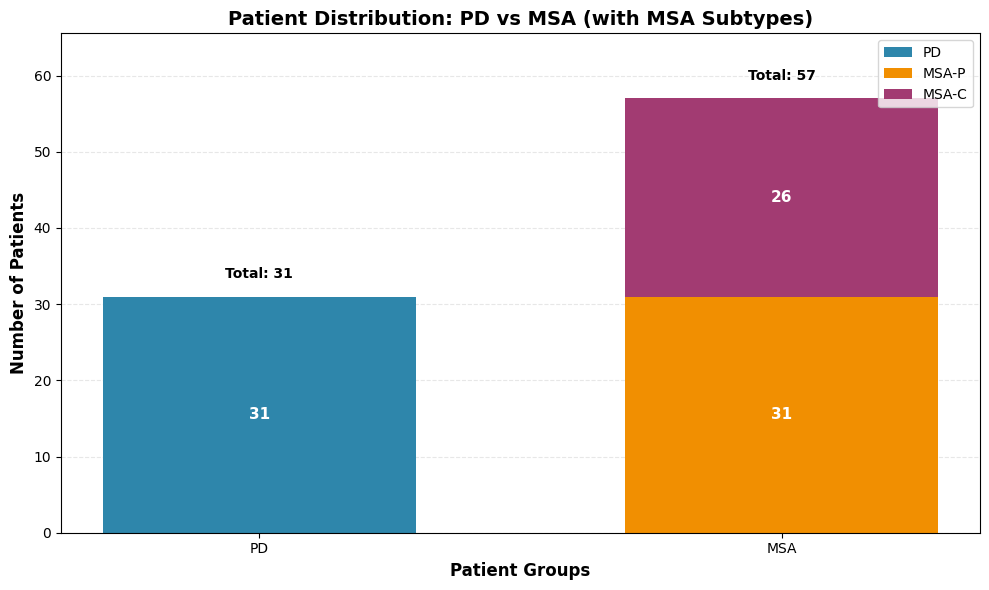

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Data
pd_count = 31
msa_c_count = 26
msa_p_count = 31
msa_total = msa_c_count + msa_p_count

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Categories and data - MSA-P at bottom, MSA-C on top
categories = ['PD', 'MSA']
pd_data = [pd_count, 0]  # PD only in first bar
msa_p_data = [0, msa_p_count]  # MSA-P at bottom in second bar
msa_c_data = [0, msa_c_count]  # MSA-C on top in second bar

# Create stacked bars
bar_width = 0.6
x_pos = np.arange(len(categories))

# Plot bars - MSA-P first (bottom), then MSA-C stacked on top
bars1 = ax.bar(x_pos, pd_data, bar_width, label='PD', color='#2E86AB', alpha=1)
bars2 = ax.bar(x_pos, msa_p_data, bar_width, label='MSA-P', color='#F18F01', alpha=1)
bars3 = ax.bar(x_pos, msa_c_data, bar_width, bottom=msa_p_data, label='MSA-C', color='#A23B72', alpha=1)

# Customize the plot
ax.set_xlabel('Patient Groups', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
ax.set_title('Patient Distribution: PD vs MSA (with MSA Subtypes)', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(categories)
ax.legend(loc='upper right')

# Add value labels on bars
for i, (bar1, bar2, bar3) in enumerate(zip(bars1, bars2, bars3)):
    if bar1.get_height() > 0:  # PD bar
        ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height()/2, 
                f'{int(bar1.get_height())}', ha='center', va='center', 
                fontweight='bold', color='white', fontsize=11)
    
    if bar2.get_height() > 0:  # MSA-P bar (now at bottom)
        ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height()/2, 
                f'{int(bar2.get_height())}', ha='center', va='center', 
                fontweight='bold', color='white', fontsize=11)
    
    if bar3.get_height() > 0:  # MSA-C bar (now on top)
        ax.text(bar3.get_x() + bar3.get_width()/2, 
                bar2.get_height() + bar3.get_height()/2, 
                f'{int(bar3.get_height())}', ha='center', va='center', 
                fontweight='bold', color='white', fontsize=11)

# Add total count labels above bars
ax.text(0, pd_count + 2, f'Total: {pd_count}', ha='center', va='bottom', 
        fontweight='bold', fontsize=10)
ax.text(1, msa_total + 2, f'Total: {msa_total}', ha='center', va='bottom', 
        fontweight='bold', fontsize=10)

# Set y-axis limit to accommodate labels
ax.set_ylim(0, max(pd_count, msa_total) * 1.15)

# Add grid for better readability
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

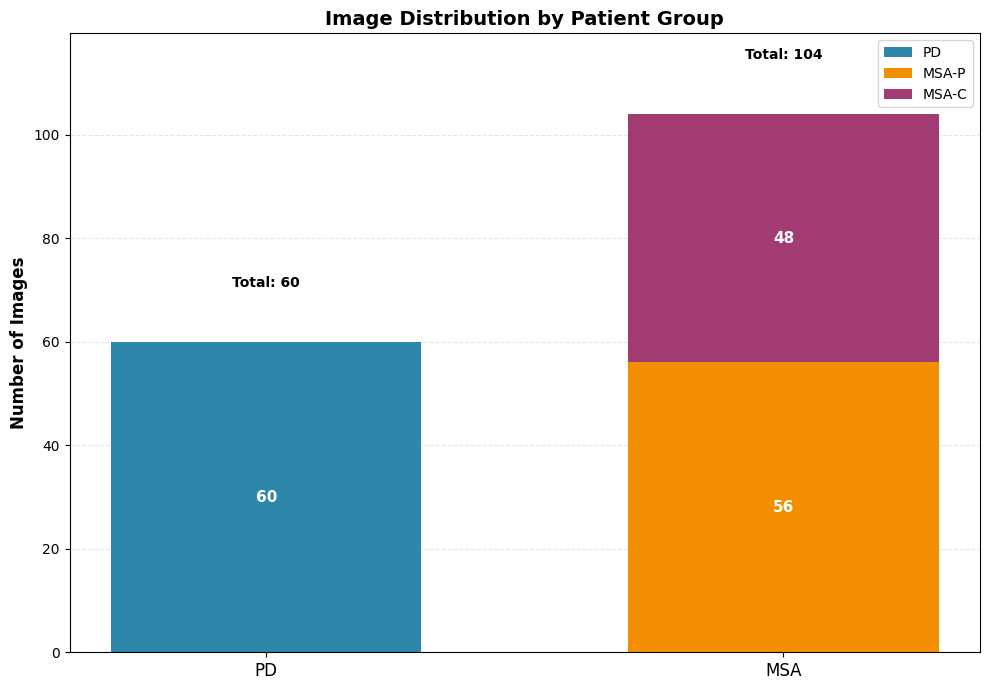

In [58]:
# --- Step 2: Create the Plot ---
fig, ax = plt.subplots(figsize=(10, 7))

# This logic is for the specific three-class scenario: PD vs MSA (stacked)
if len(class_names) == 3 and 'PD' in class_names and 'MSA-P' in class_names and 'MSA-C' in class_names:
    
    # --- Data Preparation ---
    pd_count = counts_dict['PD']['gh_count']
    msa_p_count = counts_dict['MSA-P']['gh_count'] 
    msa_c_count = counts_dict['MSA-C']['gh_count']
    
    # Define the custom labels and their positions on the x-axis
    categories = ['PD', 'MSA']
    x_pos = np.arange(len(categories))  # This will be [0, 1]

    # Structure the data to plot PD only at position 0 and MSA only at position 1
    pd_data = [pd_count, 0]
    msa_p_data = [0, msa_p_count]  # MSA-P at the bottom of the second bar
    msa_c_data = [0, msa_c_count]  # MSA-C stacked on top of MSA-P
    
    bar_width = 0.6
    
    # --- Plotting the Bars ---
    # Plot PD bar (at position 0)
    bars1 = ax.bar(x_pos, pd_data, bar_width, label='PD', color='#2E86AB', alpha=1)
    # Plot MSA-P bar (at position 1)
    bars2 = ax.bar(x_pos, msa_p_data, bar_width, label='MSA-P', color='#F18F01', alpha=1)
    # Plot MSA-C bar stacked on top of MSA-P (at position 1)
    bars3 = ax.bar(x_pos, msa_c_data, bar_width, bottom=msa_p_data, label='MSA-C', color='#A23B72', alpha=1)

    # --- Adding Value Labels inside Bars ---
    # Loop through the bars to add text labels
    for i, (bar1, bar2, bar3) in enumerate(zip(bars1, bars2, bars3)):
        if bar1.get_height() > 0:  # PD bar
            ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height()/2, 
                    f'{int(bar1.get_height())}', ha='center', va='center', 
                    fontweight='bold', color='white', fontsize=11)
        
        if bar2.get_height() > 0:  # MSA-P bar (bottom part)
            ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height()/2, 
                    f'{int(bar2.get_height())}', ha='center', va='center', 
                    fontweight='bold', color='white', fontsize=11)
        
        if bar3.get_height() > 0:  # MSA-C bar (top part)
            ax.text(bar3.get_x() + bar3.get_width()/2, 
                    bar2.get_height() + bar3.get_height()/2, # Positioned in the middle of the top segment
                    f'{int(bar3.get_height())}', ha='center', va='center', 
                    fontweight='bold', color='white', fontsize=11)
    
    # --- Adding Total Count Labels Above Bars ---
    msa_total = msa_p_count + msa_c_count
    ax.text(0, pd_count + 10, f'Total: {pd_count}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    ax.text(1, msa_total + 10, f'Total: {msa_total}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # --- Finalizing the Plot ---
    ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
    ax.set_title('Image Distribution by Patient Group', fontsize=14, fontweight='bold')
    
    # This is the key part to set the x-axis labels correctly
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories, fontsize=12)
    
    # Set y-axis limit to give space for the total labels
    max_height = max(pd_count, msa_total)
    ax.set_ylim(0, max_height * 1.15)
    
    ax.legend(loc='upper right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True) # Ensure grid is behind bars

else:
    # Fallback for other scenarios (e.g., if only two classes are present)
    ax.text(0.5, 0.5, 'This plotting logic is designed for the PD, MSA-P, MSA-C case.', 
            ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.savefig("dataset_distribution.png", dpi=300)
plt.show()


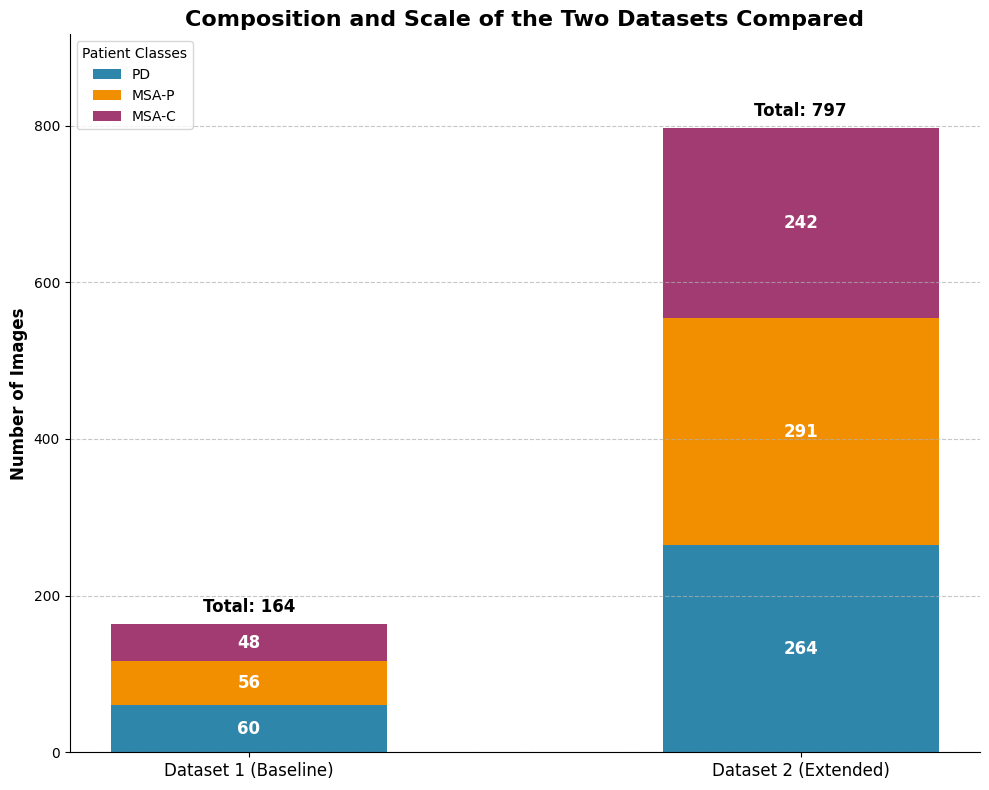

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Data extracted from your graphs
data = {
    'Dataset': ['Dataset 1 (Baseline)', 'Dataset 2 (Extended)'],
    'PD': [60, 264],
    'MSA-P': [56, 291],
    'MSA-C': [48, 242]
}
df = pd.DataFrame(data)

# Calculate the total for each dataset for the labels
df['Total'] = df['PD'] + df['MSA-P'] + df['MSA-C']

# 2. Set the colors to maintain consistency
colors = {
    'PD': '#2E86AB',
    'MSA-P': '#F18F01',
    'MSA-C': '#A23B72'
}

# 3. Plotting preparation
labels = df['Dataset']
x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

# 4. Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Bars for Dataset 1 and 2 using a loop
bottoms = np.zeros(len(df)) # Initialize the bar bottoms to zero
class_counts = {
    'PD': df['PD'].values,
    'MSA-P': df['MSA-P'].values,
    'MSA-C': df['MSA-C'].values
}

for class_name, counts in class_counts.items():
    bars = ax.bar(x, counts, width, label=class_name, color=colors[class_name], bottom=bottoms)
    
    # Add numeric labels inside each segment
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, bottoms[i] + height / 2),
                        ha='center', va='center', color='white', fontweight='bold', fontsize=12)
    
    # Update the bottoms for the next class to be stacked
    bottoms += counts

# 5. Add labels, title, and styling
ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
ax.set_title('Composition and Scale of the Two Datasets Compared', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add total labels above the bars
for i, total in enumerate(df['Total']):
    ax.text(i, total + 10, f"Total: {total}", ha='center', va='bottom', fontweight='bold', fontsize=12)

# Set y-axis limit to make space for total labels
ax.set_ylim(0, df['Total'].max() * 1.15)

# 6. Create the legend
ax.legend(title='Patient Classes', loc='upper left')

fig.tight_layout()
plt.savefig("dataset_stacked_comparison_en.png", dpi=300)
plt.show()



# ACCESSING MFLOW DATA


In [ ]:
# import os
# import pandas as pd
# import mlflow
# from mlflow.tracking import MlflowClient
# from datetime import datetime
# import re

# # Adjust if your mlruns is elsewhere
# MLRUNS_DIR = [
#     # "/home/zano/Documents/TESI/FOLDER_CINECA/notebooks/mlruns",
#     "/home/zano/Documents/TESI/FOLDER_CINECA/mlruns"
# ]

# def pick_existing_dir(candidates):
#     for d in candidates:
#         if os.path.isdir(d):
#             return d
#     raise FileNotFoundError(f"No mlruns directory found in: {candidates}")

# mlruns_dir = pick_existing_dir(MLRUNS_DIR)
# tracking_uri = f"file://{mlruns_dir}"
# mlflow.set_tracking_uri(tracking_uri)
# client = MlflowClient()

# experiments = client.search_experiments()

# EXCLUDE_PARAM_KEYS = {"seed", "random_state"}
# EXCLUDE_PARAM_PREFIXES = ["debug_", "temp_"]
# EXCLUDE_PARAM_REGEX = [r"^unused_.*"]

# experiments = client.search_experiments()  # list of Experiment objects

# EXCLUDE_PARAM_KEYS = {"seed", "random_state"}
# EXCLUDE_PARAM_PREFIXES = ["debug_", "temp_"]
# EXCLUDE_PARAM_REGEX = [r"^unused_.*"]

# # NEW: metric exclusion rules
# EXCLUDE_METRIC_KEYS = {
#     "train_loss_step",
#     "val_loss_step",
#     "val_fold_*"          # added
# }    # exact metric names
# EXCLUDE_METRIC_PREFIXES = ["raw_", "tmp_"]  # skip if starts with any of these
# EXCLUDE_METRIC_REGEX = [
#     r"^temp_.*",
#     r"^val_fold_\d+/val_a$"      # matches val_fold_0/val_a, val_fold_1/val_a, etc.
# ] # added pattern     # regex patterns to skip

# def filter_param_keys(d, exclude_keys=None, exclude_prefixes=None, exclude_regex=None):
#     for k, v in d.items():
#         if exclude_keys and k in exclude_keys:
#             continue
#         if exclude_prefixes and any(k.startswith(p) for p in exclude_prefixes):
#             continue
#         if exclude_regex and any(re.search(rx, k) for rx in exclude_regex):
#             continue
#         yield k, v

# # NEW: metric filter
# def filter_metric_keys(d, exclude_keys=None, exclude_prefixes=None, exclude_regex=None):
#     for k, v in d.items():
#         if exclude_keys and k in exclude_keys:
#             continue
#         if exclude_prefixes and any(k.startswith(p) for p in exclude_prefixes):
#             continue
#         if exclude_regex and any(re.search(rx, k) for rx in exclude_regex):
#             continue
#         yield k, v

# rows = []
# for exp in experiments:
#     exp_id = exp.experiment_id
#     runs = client.search_runs([exp_id], max_results=1000)
#     for run in runs:
#         info = run.info
#         data = run.data
#         # Flatten params
#         params = {
#             f"param.{k}": v
#             for k, v in filter_param_keys(
#                 data.params,
#                 exclude_keys=EXCLUDE_PARAM_KEYS,
#                 exclude_prefixes=EXCLUDE_PARAM_PREFIXES,
#                 exclude_regex=EXCLUDE_PARAM_REGEX
#             )
#         }
#         # Flatten metrics last logged value
#         metrics = {
#             f"metric.{k}": v
#             for k, v in filter_metric_keys(
#                 data.metrics,
#                 exclude_keys=EXCLUDE_METRIC_KEYS,
#                 exclude_prefixes=EXCLUDE_METRIC_PREFIXES,
#                 exclude_regex=EXCLUDE_METRIC_REGEX
#             )
#         }
#         tags = {f"tag.{k}": v for k, v in data.tags.items()}
#         row = {
#             "experiment_id": exp_id,
#             "experiment_name": exp.name,
#             "run_id": info.run_id,
#             "run_name": data.tags.get("mlflow.runName", ""),
#             "status": info.status,
#             "lifecycle_stage": exp.lifecycle_stage,
#             "artifact_uri": info.artifact_uri,
#             "start_time": datetime.fromtimestamp(info.start_time/1000).isoformat() if info.start_time else None,
#             "end_time": datetime.fromtimestamp(info.end_time/1000).isoformat() if info.end_time else None,
#             "duration_sec": (info.end_time - info.start_time)/1000 if (info.start_time and info.end_time) else None,
#         }
#         row.update(params)
#         row.update(metrics)
#         row.update(tags)
#         rows.append(row)

# # After collecting rows
# df = pd.DataFrame(rows)

# # Post-hoc metric column removal
# # Option A: remove ALL fold metrics
# fold_cols = [c for c in df.columns if c.startswith("metric.val_fold_")]
# print("Dropping fold metric cols:", fold_cols)
# df = df.drop(columns=fold_cols)

# pd.set_option("display.max_columns", 200)
# display(df)

# param_cols = [c for c in df.columns if c.startswith("param.")]
# param_table = df[["experiment_name","run_id","run_name"] + param_cols]
# display(param_table)

# df.to_csv("mlflow_all_runs_full.csv", index=False)
# param_table.to_csv("mlflow_all_runs_params_only.csv", index=False)
# print(f"Loaded {len(df)} runs from {len(experiments)} experiments at {tracking_uri}")

In [1]:
import os
import pandas as pd
import numpy as np
import mlflow
from mlflow.tracking import MlflowClient
from datetime import datetime
import re

# Adjust if your mlruns is elsewhere
MLRUNS_DIR_CANDIDATES = [
    # "/home/zano/Documents/TESI/FOLDER_CINECA/notebooks/mlruns",
    "/home/zano/Documents/TESI/FOLDER_CINECA/mlruns"
]

def pick_existing_dir(candidates):
    for d in candidates:
        if os.path.isdir(d):
            return d
    raise FileNotFoundError(f"No mlruns directory found in: {candidates}")

mlruns_dir = pick_existing_dir(MLRUNS_DIR_CANDIDATES)
tracking_uri = f"file://{mlruns_dir}"
mlflow.set_tracking_uri(tracking_uri)
client = MlflowClient()

experiments = client.search_experiments()

# --- Configuration for Filtering ---
EXCLUDE_PARAM_KEYS = {"seed", "random_state"}
EXCLUDE_PARAM_PREFIXES = ["debug_", "temp_"]
EXCLUDE_PARAM_REGEX = [r"^unused_.*"]

EXCLUDE_METRIC_KEYS = {"train_loss_step", "val_loss_step"}
EXCLUDE_METRIC_PREFIXES = ["raw_", "tmp_"]
EXCLUDE_METRIC_REGEX = [r"val_fold",r".*loss*"]

# --- Data Loading ---
rows = []
for exp in experiments:
    exp_id = exp.experiment_id
    runs = client.search_runs([exp_id], max_results=1000)
    for run in runs:
        info = run.info
        data = run.data
        params = {f"param.{k}": v for k, v in data.params.items()}
        metrics = {f"metric.{k}": v for k, v in data.metrics.items()}
        tags = {f"tag.{k}": v for k, v in data.tags.items()}
        row = {
            "experiment_id": exp_id,
            "experiment_name": exp.name,
            "run_id": info.run_id,
            "run_name": data.tags.get("mlflow.runName", ""),
            # "status": info.status,
            # "lifecycle_stage": exp.lifecycle_stage,
            "artifact_uri": info.artifact_uri,
            # "start_time": datetime.fromtimestamp(info.start_time/1000).isoformat() if info.start_time else None,
            # "end_time": datetime.fromtimestamp(info.end_time/1000).isoformat() if info.end_time else None,
            # "duration_sec": (info.end_time - info.start_time)/1000 if (info.start_time and info.end_time) else None,
        }
        row.update(params)
        row.update(metrics)
        row.update(tags)
        rows.append(row)

# --- DataFrame Creation and Filtering ---
df = pd.DataFrame(rows).sort_values(["experiment_name"])

param_cols_to_drop = []
for col in df.columns:
    if col.startswith("param."):
        param_name = col.replace("param.", "", 1)
        if (param_name in EXCLUDE_PARAM_KEYS or
            any(param_name.startswith(p) for p in EXCLUDE_PARAM_PREFIXES) or
            any(re.search(rx, param_name) for rx in EXCLUDE_PARAM_REGEX)):
            param_cols_to_drop.append(col)

metric_cols_to_drop = []
for col in df.columns:
    if col.startswith("metric."):
        metric_name = col.replace("metric.", "", 1)
        if (metric_name in EXCLUDE_METRIC_KEYS or
            any(metric_name.startswith(p) for p in EXCLUDE_METRIC_PREFIXES) or
            any(re.search(rx, metric_name) for rx in EXCLUDE_METRIC_REGEX)):
            metric_cols_to_drop.append(col)

cols_to_drop = param_cols_to_drop + metric_cols_to_drop
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print(f"Dropped {len(cols_to_drop)} parameter/metric columns based on exclusion rules.")


# Create a boolean mask for rows to keep
mask = (df['experiment_name'].str.startswith('SL', na=False) | 
        df['experiment_name'].str.startswith('pretrained', na=False))

# Apply the filter
df = df[mask]

#drop columns with loss in their name
loss_cols = [col for col in df.columns if 'loss' in col.lower()]
df.drop(columns=loss_cols, inplace=True, errors='ignore')
print(f"Dropped {len(loss_cols)} columns containing 'loss': {loss_cols}")

print(f"After filtering, {len(df)} runs remain with experiment names starting with 'SL' or 'pretrained'")

# --- Add DATASET Column ---
if 'param.test_counts' in df.columns:
    df['param.test_counts'] = pd.to_numeric(df['param.test_counts'], errors='coerce')
    df['dataset'] = np.where(df['param.test_counts'] < 25, 'DS1', 'DS2')
    print("Added 'dataset' column based on 'param.test_counts'.")
else:
    print("Warning: 'param.test_counts' column not found. Could not create 'dataset' column.")

# --- Add num_channels Column ---
# Condition A: '3c' is in the experiment name string.
condition_3c = df['experiment_name'].str.contains("3c", na=False)

# Condition B: 'param.transfer_learning' is the string 'True'.
if 'param.transfer_learning' in df.columns:
    condition_tl = (df['param.transfer_learning'] == 'True')
else:
    condition_tl = pd.Series([False] * len(df), index=df.index)
    print("Warning: 'param.transfer_learning' column not found. Assuming False for this condition.")

# Combine the two conditions with a logical OR (|)
is_3_channels = condition_3c | condition_tl

# Use np.where to create the column: if the combined condition is True, assign 3, otherwise 4.
df['num_channels'] = np.where(is_3_channels, 3, 4)
print("Added 'num_channels' column based on experiment name and transfer learning param.")

# --- NEW: Add classi Column ---
# Create a condition to check if the experiment name contains the specific substring
condition_msap = df['experiment_name'].str.contains("_MSA-P_vs_PD_", na=False)

# Use np.where to assign the value based on the condition
df['classes'] = np.where(condition_msap, 'MSA-P vs PD', 'MSA vs PD')
print("Added 'classes' column based on experiment name.")

# --- Correct param.color_transforms based on run_name due to error in logging code---
if 'run_name' in df.columns and 'param.color_transforms' in df.columns:
    # Create a boolean mask for rows where run_name contains the specific string
    color_transform_mask = df['run_name'].str.contains('_color_transforms:True_', na=False)
    
    # Update the 'param.color_transforms' column to True where the mask is True
    df.loc[color_transform_mask, 'param.color_transforms'] = 'True'
    print("Updated 'param.color_transforms' based on 'run_name' content.")

# --- Create, Display, and Save Final Merged Table ---
# The main 'df' DataFrame now contains all info. We will reorder it for better readability.

# Define the desired column order, including the new 'classes' column
id_cols = ['experiment_name', 'run_name', 'dataset', 'classes', 'num_channels']
param_cols = sorted([c for c in df.columns if c.startswith("param.")])
metric_cols = sorted([c for c in df.columns if c.startswith("metric.")])

# Construct the final list of columns, ensuring they exist in the DataFrame
final_cols_order = [col for col in id_cols if col in df.columns] + \
                   [col for col in param_cols if col in df.columns] + \
                   [col for col in metric_cols if col in df.columns]

# Create the final, reordered dataframe
results_df = df[final_cols_order]

# Replace 'torchvision' with 'imagenet' in the 'param.pretrained' column
if 'param.pretrained' in results_df.columns:
    results_df['param.pretrained'] = results_df['param.pretrained'].replace('torchvision', 'imagenet')
    print("Replaced 'torchvision' with 'imagenet' in 'param.pretrained' column.")

pd.set_option("display.max_columns", 200)
print("\n--- Final Merged Results Table ---")
display(results_df)

# Save the single, merged DataFrame to a CSV file
results_df.to_csv("mlflow_results_merged.csv", index=False)
print("\nSaved the final merged table to 'mlflow_results_merged.csv'")

print(f"\nLoaded and processed {len(df)} runs from {len(experiments)} experiments at {tracking_uri}")

Dropped 82 parameter/metric columns based on exclusion rules.
Dropped 0 columns containing 'loss': []
After filtering, 83 runs remain with experiment names starting with 'SL' or 'pretrained'
Added 'dataset' column based on 'param.test_counts'.
Added 'num_channels' column based on experiment name and transfer learning param.
Added 'classes' column based on experiment name.
Updated 'param.color_transforms' based on 'run_name' content.
Replaced 'torchvision' with 'imagenet' in 'param.pretrained' column.

--- Final Merged Results Table ---


/tmp/ipykernel_55426/2727140077.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['param.pretrained'] = results_df['param.pretrained'].replace('torchvision', 'imagenet')


,experiment_name,run_name,dataset,classes,num_channels,param.batch_size,param.color_transforms,param.dropout_rate,param.epochs,param.fine_tuning,param.freezed_layer_index,param.model_library,param.model_name,param.n_folds,param.num_channels,param.pretrained,param.test_counts,param.total_params,param.train_counts,param.trainable_params,param.transfer_learning,param.val_counts,param.weight_decay,metric.exec_time_min,metric.mean_test_accuracy,metric.mean_test_auc,metric.mean_test_balanced_acc,metric.mean_test_f1,metric.mean_test_mcc,metric.mean_test_precision,metric.mean_test_recall,metric.std_test_accuracy,metric.std_test_auc,metric.std_test_balanced_acc,metric.std_test_f1,metric.std_test_mcc,metric.std_test_precision,metric.std_test_recall
33,SL_Single_MIP_MSA-P_vs_PD_supervised,Densenet121_oversamp_monai_color_transforms:Fa...,DS1,MSA-P vs PD,4,32,False,0.2,210,False,None,monai,Densenet121,8,NaN,None,14,6959042,"{0: 85, 1: 85, 2: 84, 3: 88, 4: 86, 5: 86, 6: ...",6959042,False,"{0: 16, 1: 15, 2: 15, 3: 16, 4: 16, 5: 16, 6: ...",1e-4,16.801926,0.762045,0.814949,0.749504,0.759333,0.517510,0.750595,0.791667,0.126940,0.147732,0.141469,0.162505,0.288895,0.146001,0.217506
32,SL_Single_MIP_MSA-P_vs_PD_supervised,Resnet18_oversamp_monai_color_transforms:False...,DS1,MSA-P vs PD,4,32,False,0.2,210,False,None,monai,Resnet18,8,NaN,None,14,11181570,"{0: 85, 1: 85, 2: 84, 3: 88, 4: 86, 5: 86, 6: ...",11181570,False,"{0: 16, 1: 15, 2: 15, 3: 16, 4: 16, 5: 16, 6: ...",1e-4,16.701304,0.707690,0.769841,0.714782,0.655765,0.443263,0.749653,0.630208,0.186351,0.197368,0.177059,0.257787,0.362726,0.218945,0.297149
31,SL_Single_MIP_MSA-P_vs_PD_supervised,Resnet50_oversamp_monai_color_transforms:False...,DS1,MSA-P vs PD,4,64,False,0.2,210,False,None,monai,Resnet50,8,NaN,None,14,23519106,"{0: 85, 1: 85, 2: 84, 3: 88, 4: 86, 5: 86, 6: ...",23519106,False,"{0: 16, 1: 15, 2: 15, 3: 16, 4: 16, 5: 16, 6: ...",1e-4,34.348487,0.648915,0.700893,0.648313,0.573853,0.339689,0.524242,0.687500,0.173259,0.201756,0.163289,0.350405,0.335469,0.338144,0.428478
30,SL_Single_MIP_MSA-P_vs_PD_supervised,Densenet169_oversamp_monai_color_transforms:Fa...,DS1,MSA-P vs PD,4,32,False,0.2,210,False,None,monai,Densenet169,8,4,None,14,12490946,"{0: 85, 1: 85, 2: 84, 3: 88, 4: 86, 5: 86, 6: ...",12490946,False,"{0: 16, 1: 15, 2: 15, 3: 16, 4: 16, 5: 16, 6: ...",1e-4,20.146460,0.786139,0.820312,0.780754,0.796355,0.581236,0.764187,0.843750,0.123389,0.129428,0.124883,0.137937,0.255682,0.151640,0.162380
29,SL_Single_MIP_MSA-P_vs_PD_supervised,Densenet121_oversamp_monai_color_transforms:Tr...,DS1,MSA-P vs PD,4,32,True,0.2,210,False,None,monai,Densenet121,8,4,None,14,6959042,"{0: 85, 1: 85, 2: 84, 3: 88, 4: 86, 5: 86, 6: ...",6959042,False,"{0: 16, 1: 15, 2: 15, 3: 16, 4: 16, 5: 16, 6: ...",1e-4,30.768551,0.752468,0.754588,0.745164,0.785639,0.504013,0.748512,0.854167,0.158857,0.225605,0.165901,0.137165,0.336873,0.188220,0.135015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,pretrained_subslice_MSA_vs_PD_supervised,Densenet169_oversamp_TL_pretrained:microscopyn...,DS2,MSA vs PD,3,32,False,0.2,210,False,308,monai,Densenet169,8,NaN,microscopynet,117,12487810,"{0: 589, 1: 588, 2: 586, 3: 594, 4: 597, 5: 59...",6742018,True,"{0: 105, 1: 104, 2: 104, 3: 105, 4: 106, 5: 10...",1e-4,79.836654,0.622708,0.650792,0.586062,0.468144,0.176650,0.463703,0.487588,0.106976,0.111636,0.081521,0.083341,0.173435,0.112981,0.086862
39,pretrained_subslice_MSA_vs_PD_supervised,Resnet18_oversamp_TL_pretrained:microscopynet_...,DS2,MSA vs PD,3,64,False,0.2,210,False,50,torchvision,Resnet18,8,NaN,microscopynet,117,11177538,"{0: 576, 1: 574, 2: 572, 3: 580, 4: 583, 5: 58...",4853762,True,"{0: 118, 1: 118, 2: 118, 3: 119, 4: 120, 5: 11...",2e-4,85.895663,0.685517,0.732656,0.638859,0.516812,0.279322,0.517154,0.525146,0.044608,0.067434,0.045625,0.096532,0.085201,0.070589,0.121456
38,pretrained_subslice_MSA_vs_P


Saved the final merged table to 'mlflow_results_merged.csv'

Loaded and processed 83 runs from 19 experiments at file:///home/zano/Documents/TESI/FOLDER_CINECA/mlruns


 # GRAPHS

Grafico filtrato salvato come 'model_comparison_filtered.png'


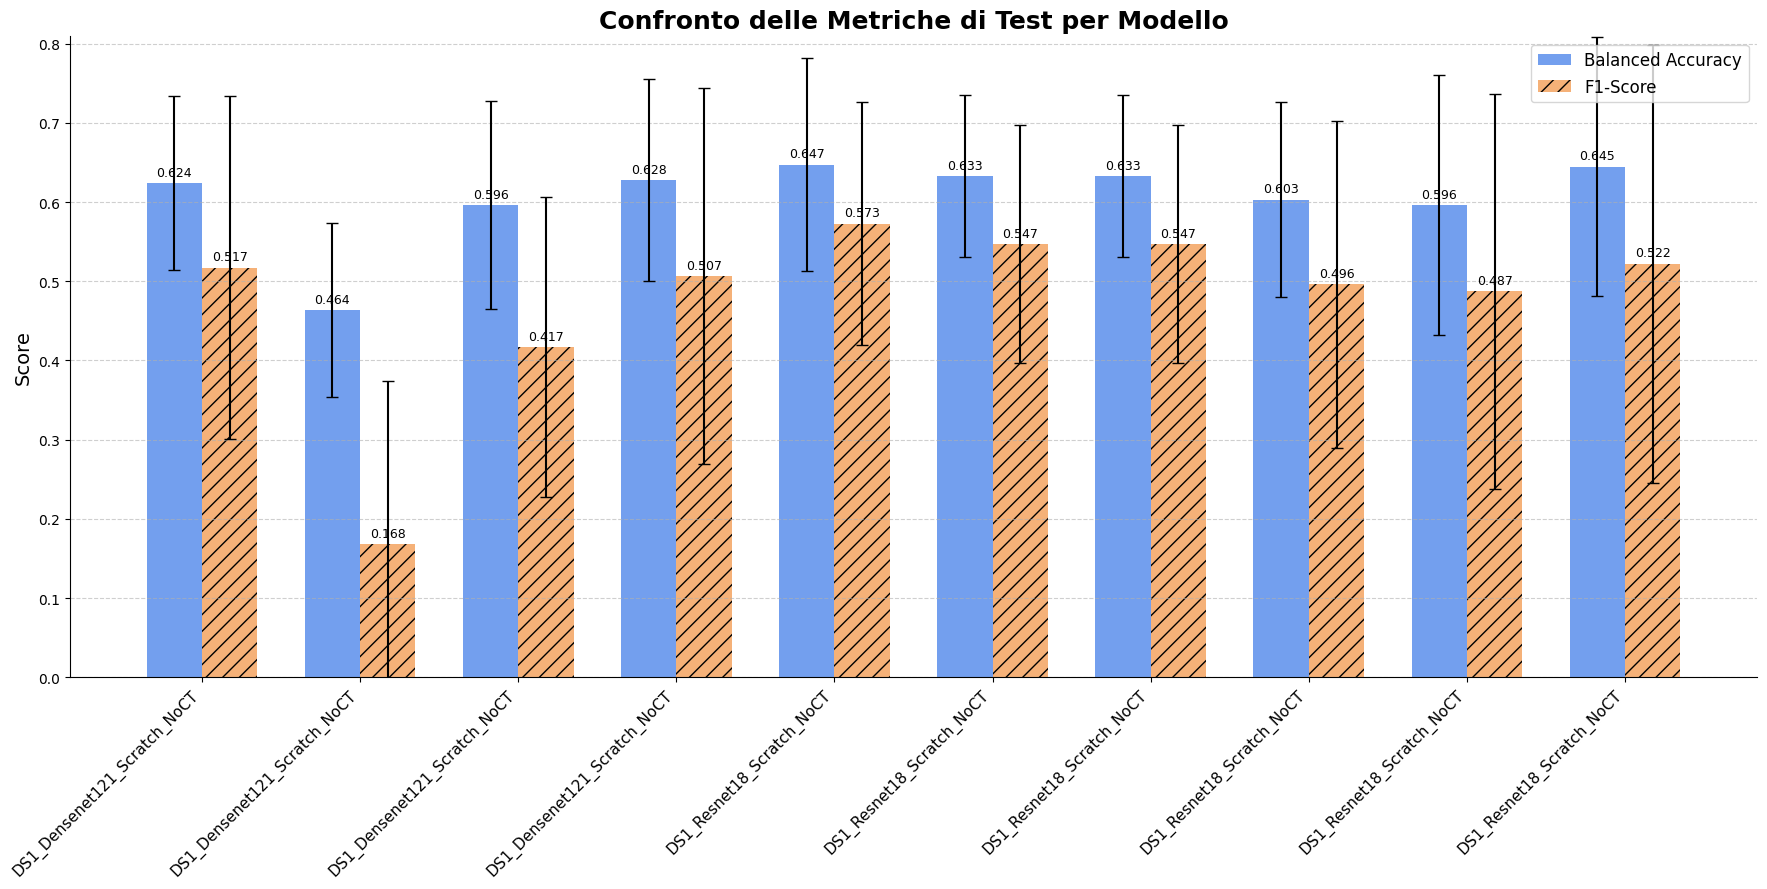

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. CONFIGURAZIONE DEI FILTRI ---
# Modifica questi valori per selezionare i modelli da visualizzare nel grafico.
# Lascia una lista vuota [] per non applicare un filtro su quel parametro.
FILTER_CONFIG = {
    'dataset': ['DS1'],                          # Esempio: ['DS1'] oppure ['DS1', 'DS2']
    'classes': ["MSA vs PD"],                      # Esempio: "MSA vs PD"
    'num_channels': [4],                         # Esempio: [3] oppure [1, 3]
    'param.transfer_learning': [False],          # Esempio: [True]
    'param.color_transforms': [False],           # Esempio: [True] o [False]
    'param.model_name': ["Densenet121","Resnet18"]                       # NUOVO FILTRO! Esempio: ['Densenet121', 'Resnet18']
}

# --- 2. NOMI DI COLONNE E METRICHE ---
# Parametri per filtrare
PARAM_DATASET = 'dataset'
PARAM_CLASSES = 'classes'
PARAM_CHANNELS = 'num_channels'
PARAM_PRETRAINED = 'param.transfer_learning'
PARAM_COLOR_TRANSFORMS = 'param.color_transforms'
PARAM_MODEL_NAME = 'param.model_name' # NUOVA COSTANTE
# Metriche da visualizzare
METRIC_ACC_MEAN = 'metric.mean_test_balanced_acc'
METRIC_ACC_STD = 'metric.std_test_balanced_acc'
METRIC_F1_MEAN = 'metric.mean_test_f1'
METRIC_F1_STD = 'metric.std_test_f1'


# --- 3. CARICAMENTO E FILTRAGGIO DEI DATI ---
try:
    results_df = pd.read_csv('mlflow_results_merged.csv')
except FileNotFoundError:
    print("Errore: File 'mlflow_results_merged.csv' non trovato.")
    exit()

# Applica i filtri definiti in FILTER_CONFIG
filtered_df = results_df.copy()
for key, values in FILTER_CONFIG.items():
    if values:  # Applica il filtro solo se la lista non è vuota
        try:
            # Gestione robusta dei tipi di dato per il filtro
            if results_df[key].dtype == 'bool':
                filtered_df = filtered_df[filtered_df[key].isin(values)]
            else:
                filtered_df = filtered_df[filtered_df[key].astype(str).isin([str(v) for v in values])]
        except KeyError:
            print(f"Attenzione: La colonna '{key}' non è stata trovata nel CSV. Filtro ignorato.")


if filtered_df.empty:
    print("Nessun dato corrisponde ai filtri impostati. Impossibile generare il grafico.")
    exit()


def create_run_name(row):
    try:
        # Usa .get() per evitare errori se le colonne mancano in alcune run
        tl = "TL" if row.get(PARAM_PRETRAINED, False) else "Scratch"
        ds = row.get(PARAM_DATASET, 'N/A')
        model_name = row.get('param.model_name', 'UnknownModel')
        ct_info = "CT" if row.get(PARAM_COLOR_TRANSFORMS, False) else "NoCT"
        
        weights_info = ""
        if row.get(PARAM_PRETRAINED, False):
            weights_info = row.get("param.pretrained", "")
            weights_info = f"_{weights_info}" if weights_info else ""
            
        # AGGIORNATO per includere ct_info
        return f"{ds}_{model_name}_{tl}_{ct_info}{weights_info}"
    except Exception:
        return "Nome Run Sconosciuto"

filtered_df['run_name'] = filtered_df.apply(create_run_name, axis=1)
# Ordina i risultati per una visualizzazione più pulita
filtered_df = filtered_df.sort_values(by='run_name').reset_index()

# --- 4. ESTRAZIONE DATI PER IL GRAFICO ---
labels = filtered_df['run_name']
acc_means = filtered_df[METRIC_ACC_MEAN]
acc_stds = filtered_df[METRIC_ACC_STD]
f1_means = filtered_df[METRIC_F1_MEAN]
f1_stds = filtered_df[METRIC_F1_STD]

# --- 5. CREAZIONE DEL GRAFICO ---
fig, ax = plt.subplots(figsize=(18, 9))

x = np.arange(len(labels))  # le posizioni delle etichette
width = 0.35  # la larghezza delle barre

# Disegna le barre della Balanced Accuracy (solide)
rects1 = ax.bar(x - width/2, acc_means, width, label='Balanced Accuracy', 
                yerr=acc_stds, capsize=4, color='cornflowerblue', alpha=0.9)

# Disegna le barre dell'F1-Score (tratteggiate)
rects2 = ax.bar(x + width/2, f1_means, width, label='F1-Score', 
                yerr=f1_stds, capsize=4, color='sandybrown', hatch='//', alpha=0.85)

# --- 6. AGGIUNTA DI ETICHETTE E STILE ---
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Confronto delle Metriche di Test per Modello', fontsize=18, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=11)
ax.legend(fontsize=12)

# Calcola il limite superiore dell'asse y in modo sicuro
all_means = pd.concat([acc_means, f1_means]).dropna()
if all_means.empty:
    max_val = 1.0
else:
    max_val = all_means.max()
ax.set_ylim(0, max_val * 1.25)

# Funzione per aggiungere i valori numerici sopra le barre
def add_value_labels(rects):
    for rect in rects:
        height = rect.get_height()
        if pd.notna(height):
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

add_value_labels(rects1)
add_value_labels(rects2)

# Migliora il layout generale
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()

# --- 7. SALVATAGGIO E VISUALIZZAZIONE ---
plt.savefig("model_comparison_filtered.png", dpi=300, bbox_inches='tight')
print("Grafico filtrato salvato come 'model_comparison_filtered.png'")
plt.show()

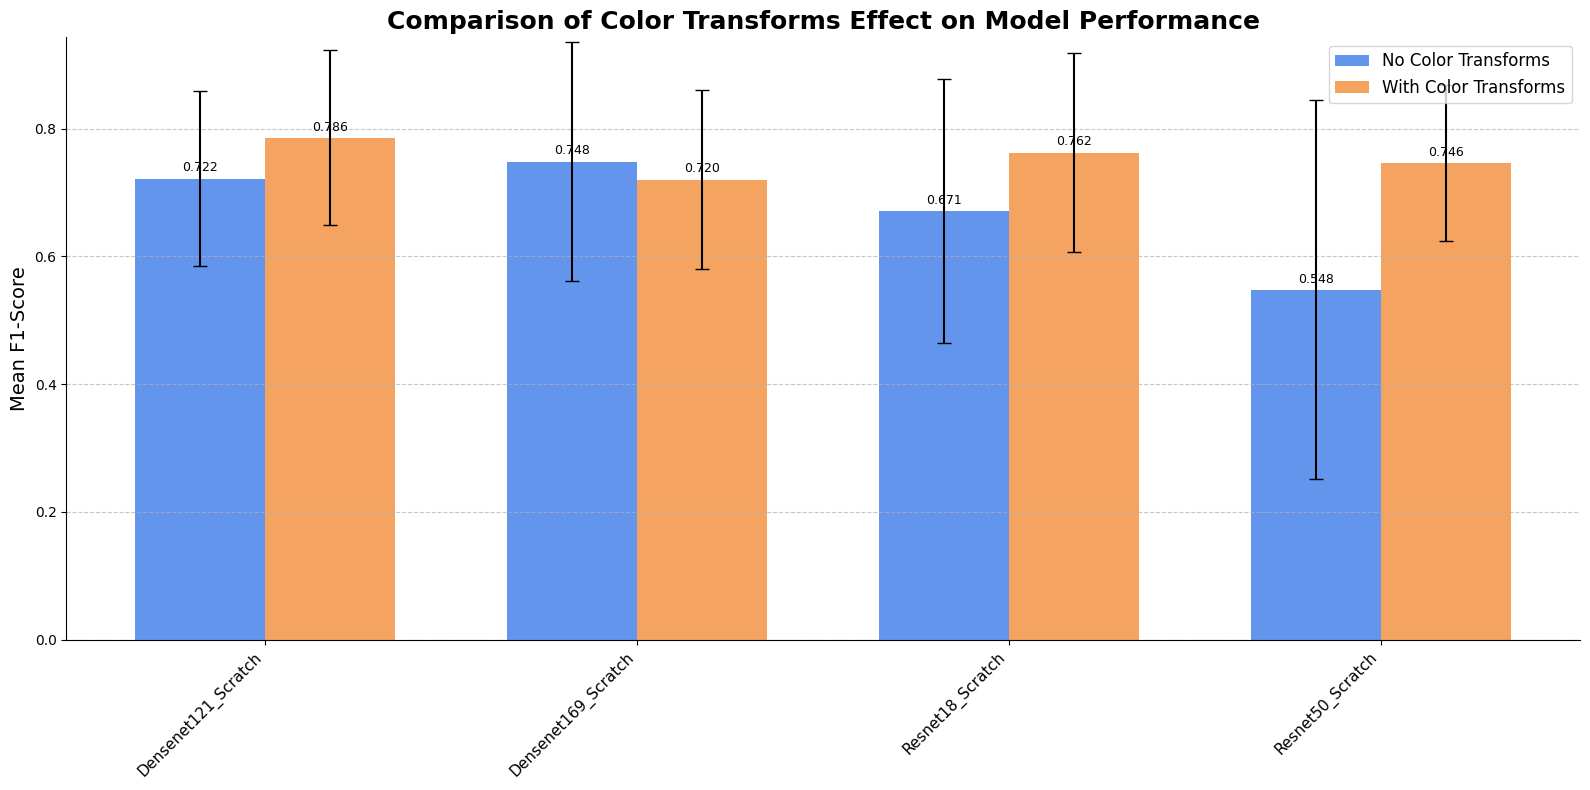

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. CONFIGURATION ---
# Define the base scenario you want to compare.
FILTER_CONFIG = {
    'dataset': ['DS1'],
    'classes': ["MSA-P vs PD"],
    'param.transfer_learning': [False] # Use [True] for TL, [False] for Scratch
}

# CHOOSE THE METRIC TO VISUALIZE: 'Balanced Accuracy' or 'F1-Score'
METRIC_CHOICE = 'F1-Score'  # Change to 'Balanced Accuracy' if desired

# --- 2. COLUMN AND METRIC NAMES ---
PARAM_COLOR = 'param.color_transforms'

# Map friendly names to metric column names
METRIC_MAP = {
    'Balanced Accuracy': 'test_balanced_acc',
    'F1-Score': 'test_f1'
}
metric_base_name = METRIC_MAP.get(METRIC_CHOICE, 'test_balanced_acc')
METRIC_MEAN = f'metric.mean_{metric_base_name}'
METRIC_STD = f'metric.std_{metric_base_name}'


# --- 3. DATA LOADING AND PREPARATION ---
try:
    results_df = pd.read_csv('mlflow_results_merged.csv')
except FileNotFoundError:
    print("Error: File 'mlflow_results_merged.csv' not found.")
    # In a notebook, you might want to exit the cell execution here.
    # For this example, we'll let it raise an error.

# Apply base filters
plot_df = results_df.copy()
for key, values in FILTER_CONFIG.items():
    if values:
        try:
            # Convert boolean values to string for comparison, as they are often loaded as strings from CSV
            plot_df = plot_df[plot_df[key].astype(str).isin([str(v) for v in values])]
        except KeyError:
            print(f"Warning: Column '{key}' not found. Filter ignored.")

# Ensure the color transform parameter is boolean for easier pivoting
plot_df[PARAM_COLOR] = plot_df[PARAM_COLOR].astype(str).str.lower() == 'true'

# Create a unique name for each model configuration (excluding color transforms)
def create_model_id(row):
    model_name = row.get('param.model_name', 'UnknownModel')
    tl_status = "TL" if str(row.get('param.transfer_learning', 'False')).lower() == 'true' else "Scratch"
    return f"{model_name}_{tl_status}"

plot_df['model_id'] = plot_df.apply(create_model_id, axis=1)

# Pivot the table to get 'True' and 'False' values in separate columns
pivot_df = plot_df.pivot_table(
    index='model_id',
    columns=PARAM_COLOR,
    values=[METRIC_MEAN, METRIC_STD]
).reset_index()

# Flatten the multi-level column names (e.g., ('metric.mean_test_balanced_acc', False) -> 'metric.mean_test_balanced_acc_False')
pivot_df.columns = [f'{col[0]}_{col[1]}' if isinstance(col, tuple) and col[1] != '' else col[0] for col in pivot_df.columns]
pivot_df = pivot_df.sort_values(by='model_id')

if pivot_df.empty:
    print("No data matches the filters for comparison. Cannot generate graph.")
else:
    # --- 4. PLOTTING ---
    labels = pivot_df['model_id']
    means_no_color = pivot_df.get(f'{METRIC_MEAN}_False', pd.Series(0, index=pivot_df.index))
    stds_no_color = pivot_df.get(f'{METRIC_STD}_False', pd.Series(0, index=pivot_df.index))
    means_color = pivot_df.get(f'{METRIC_MEAN}_True', pd.Series(0, index=pivot_df.index))
    stds_color = pivot_df.get(f'{METRIC_STD}_True', pd.Series(0, index=pivot_df.index))

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(16, 8))

    # Bars for 'No Color Transforms'
    rects1 = ax.bar(x - width/2, means_no_color, width, label='No Color Transforms',
                    yerr=stds_no_color, capsize=5, color='cornflowerblue')

    # Bars for 'With Color Transforms'
    rects2 = ax.bar(x + width/2, means_color, width, label='With Color Transforms',
                    yerr=stds_color, capsize=5, color='sandybrown')

    # --- 5. LABELS AND STYLING ---
    ax.set_ylabel(f'Mean {METRIC_CHOICE}', fontsize=14)
    ax.set_title('Comparison of Color Transforms Effect on Model Performance', fontsize=18, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=11)
    ax.legend(fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set Y-axis limit
    max_val = max(means_no_color.max(), means_color.max())
    ax.set_ylim(0, max_val * 1.2 if pd.notna(max_val) and max_val > 0 else 1.0)

    # Function to add value labels
    def add_value_labels(rects):
        for rect in rects:
            height = rect.get_height()
            if pd.notna(height) and height > 0:
                ax.annotate(f'{height:.3f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=9)

    add_value_labels(rects1)
    add_value_labels(rects2)

    fig.tight_layout()
    
    # --- 6. SAVE AND SHOW ---
    # plt.savefig("color_transform_comparison.png", dpi=300, bbox_inches='tight')
    # print("Graph saved as 'color_transform_comparison.png'")
    plt.show()